# Objective
**- To classify the given leaf image as ['FRESH', 'HALF-FRESH', 'SPOILED']**<br>
**- Meat Freshness Image Classification   problem**<br>

# Dependencies

In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

print(tf.__version__)
############ settings ############
data_dir = r"meat"

batch_size = 32
img_height = 128
img_width = 128

2.5.0


# Data preprocessing

**- Loading and splitting data<br>**
**- Train:80% and Validation:20%**

In [2]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 182 files belonging to 3 classes.
Using 146 files for training.
Found 182 files belonging to 3 classes.
Using 36 files for validation.


# EDA

2022-11-11 14:07:40.734757: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


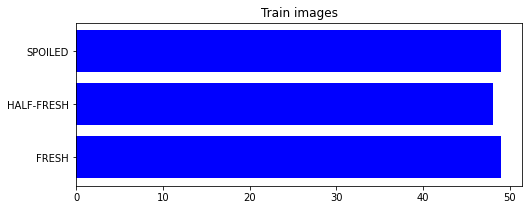

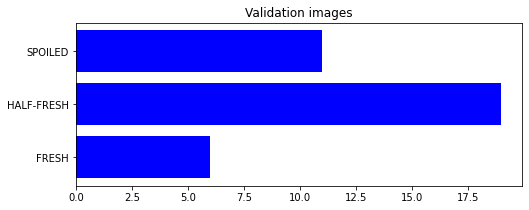

In [3]:
def plot_distribution(y, title):
    a = Counter(y)
    y = ['FRESH', 'HALF-FRESH', 'SPOILED']
    
    x = [a[i] for i in range(3)]
    plt.figure(figsize=(8, 3))
    plt.barh(y, x, color='blue')
    plt.title(title)
    return plt.show()

y_train = np.concatenate([y for x, y in train_ds], axis=0)
y_val = np.concatenate([y for x, y in val_ds], axis=0)

plot_distribution(y_train, title="Train images")
plot_distribution(y_val, title = "Validation images")

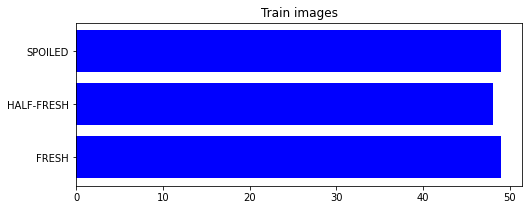

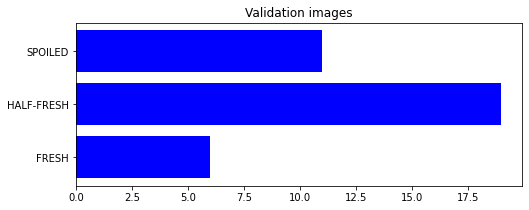

In [4]:
# Target distribution

y_train = np.concatenate([y for x, y in train_ds], axis=0)
y_val = np.concatenate([y for x, y in val_ds], axis=0)

plot_distribution(y_train, title="Train images")
plot_distribution(y_val, title = "Validation images")

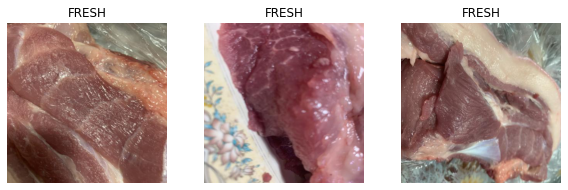

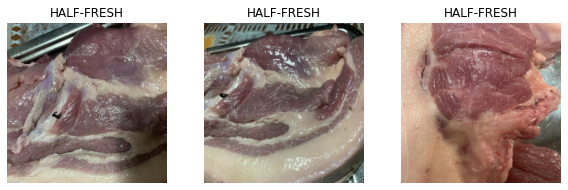

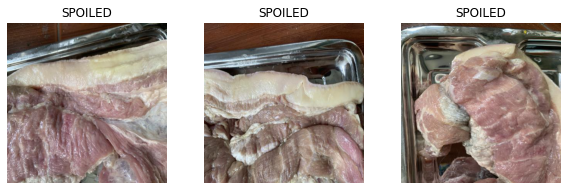

In [5]:
## Sample images
class_names = train_ds.class_names

for class_name in class_names:
    imgs = os.listdir(os.path.join(data_dir, class_name))[:3]
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(imgs):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(plt.imread(os.path.join(data_dir, class_name, img)))
        plt.title(class_name)
        plt.axis('off')

# Model Training

In [6]:
# Configure the dataset for performance

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
# Model architecture

num_classes = 3

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),

    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(num_classes, activation='softmax')

])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                      min_delta=0.0001,
                                                      patience=5)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=20,
                    callbacks=[earlystop_callback])

Epoch 1/20
5/5 [==============================] - 4s 566ms/step - loss: 1.2254 - accuracy: 0.3630 - val_loss: 1.1307 - val_accuracy: 0.1667
Epoch 2/20
5/5 [==============================] - 2s 438ms/step - loss: 1.0834 - accuracy: 0.4110 - val_loss: 1.0787 - val_accuracy: 0.3056
Epoch 3/20
5/5 [==============================] - 2s 434ms/step - loss: 1.0505 - accuracy: 0.4863 - val_loss: 1.0569 - val_accuracy: 0.4444
Epoch 4/20
5/5 [==============================] - 2s 442ms/step - loss: 0.9839 - accuracy: 0.5616 - val_loss: 1.0216 - val_accuracy: 0.3611
Epoch 5/20
5/5 [==============================] - 2s 457ms/step - loss: 0.9106 - accuracy: 0.5753 - val_loss: 0.9396 - val_accuracy: 0.5000
Epoch 6/20
5/5 [==============================] - 2s 495ms/step - loss: 0.8188 - accuracy: 0.6986 - val_loss: 0.8069 - val_accuracy: 0.6667
Epoch 7/20
5/5 [==============================] - 3s 511ms/step - loss: 0.8230 - accuracy: 0.6233 - val_loss: 0.7228 - val_accuracy: 0.7222
Epoch 8/20
5/5 [====

# Model Evaluation

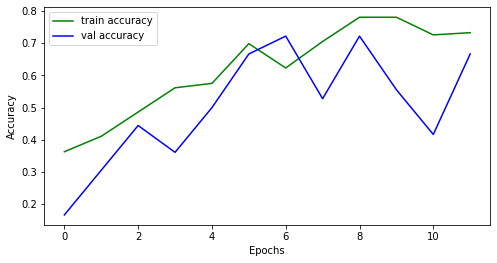

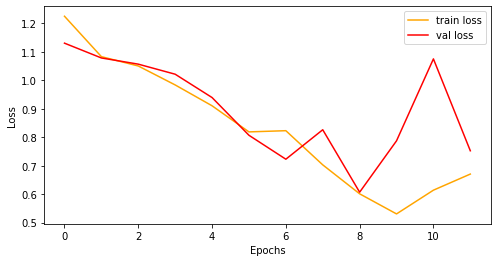

In [8]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
valid_loss = history.history['val_loss']
valid_acc = history.history['val_accuracy']

# Accuracy plots
plt.figure(figsize=(8, 4))
plt.plot(train_acc, color='green', linestyle='-', label='train accuracy')
plt.plot(valid_acc, color='blue', linestyle='-', label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# loss plots
plt.figure(figsize=(8, 4))
plt.plot(train_loss, color='orange', linestyle='-', label='train loss')
plt.plot(valid_loss, color='red', linestyle='-', label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
loss, acc = model.evaluate(val_ds, batch_size=batch_size)
print("validation accuracy :", round(acc, 2))
print("validation loss :", round(loss,2))

2/2 [==============================] - 0s 29ms/step - loss: 0.7524 - accuracy: 0.6667
validation accuracy : 0.67
validation loss : 0.75


In [10]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in val_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

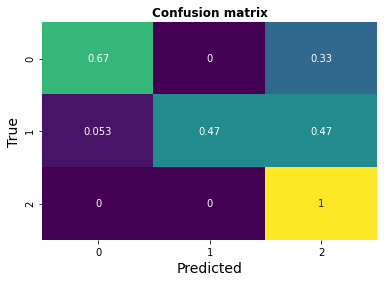

In [11]:
cm = confusion_matrix(correct_labels, predicted_labels, normalize='true')
sns.heatmap(cm, annot=True, cmap='viridis', cbar=None)
plt.title("Confusion matrix", fontweight='bold')
plt.ylabel("True", fontsize=14)
plt.xlabel("Predicted", fontsize=14)
plt.show()

In [12]:
print(classification_report(correct_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       1.00      0.47      0.64        19
           2       0.50      1.00      0.67        11

    accuracy                           0.67        36
   macro avg       0.77      0.71      0.68        36
weighted avg       0.81      0.67      0.66        36



# Post Processing

In [13]:
# Save
model.save("model_v1.h5")

In [14]:
def prediction(img):
    class_names = ['fresh_meat', 'half freash', 'SPOILED']

    my_image = load_img(img, target_size=(img_height, img_width))
    my_image = img_to_array(my_image)
    my_image = np.expand_dims(my_image, 0)

    out = np.round(model.predict(my_image)[0], 2)
    fig = plt.figure(figsize=(7, 4))
    plt.barh(class_names, out, color='lightgray',edgecolor='red', linewidth=1, height=0.5)

    for index, value in enumerate(out):
        plt.text(value/2 + 0.1, index, f"{100*value:.2f}%", fontweight='bold')

    plt.xticks([])
    plt.yticks([0, 1, 2], labels=class_names, fontweight='bold', fontsize=14)
    fig.savefig('pred_img.png', bbox_inches='tight')
    return plt.show()

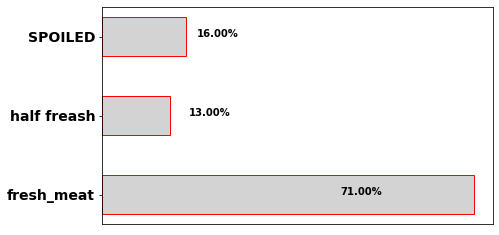

In [15]:
####### Prediction on single Image
img = 'fesh.jpg'
prediction(img)

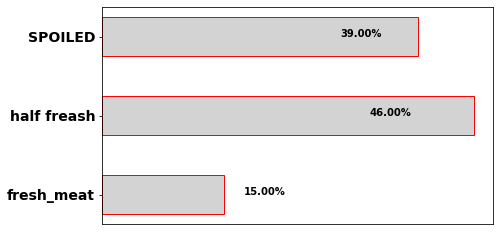

In [16]:
####### Prediction on single Image
img = 'half.jpg'
prediction(img)

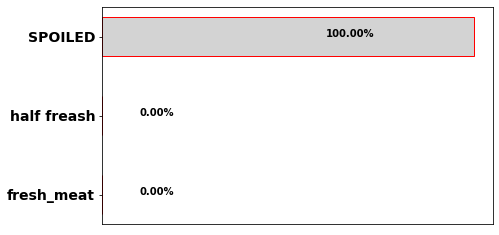

In [17]:
####### Prediction on single Image
img = 's.jpg'
prediction(img)